In [54]:
# -----------------------------
# 1. Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")

In [53]:
# -----------------------------
# 2. Load Datasets
# -----------------------------
history_df = pd.read_csv('Coca-Cola_stock_history.csv')
info_df = pd.read_csv('Coca-Cola_stock_info.csv')

In [107]:
# -----------------------------
# 3. Basic Info
# -----------------------------
print("Stock History - Shape:", history_df.shape)
print("Stock Info - Shape:", info_df.shape)
print("Stock History - Columns:", history_df.columns.tolist())
print("Stock Info - Columns:", info_df.columns.tolist())

Stock History - Shape: (15311, 8)
Stock Info - Shape: (153, 2)
Stock History - Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
Stock Info - Columns: ['Key', 'Value']


In [108]:
# -----------------------------
# 4. Sample and Nulls
# -----------------------------
print("Sample Stock History Data:", history_df.head())
print("Sample Stock Info Data:", info_df.head())
print("Missing values in History:", history_df.isnull().sum())
print("Missing values in Info:", info_df.isnull().sum())

Sample Stock History Data:          Date      Open      High       Low     Close   Volume  Dividends  \
0  1962-01-02  0.050016  0.051378  0.050016  0.050016   806400        0.0   
1  1962-01-03  0.049273  0.049273  0.048159  0.048902  1574400        0.0   
2  1962-01-04  0.049026  0.049645  0.049026  0.049273   844800        0.0   
3  1962-01-05  0.049273  0.049892  0.048035  0.048159  1420800        0.0   
4  1962-01-08  0.047787  0.047787  0.046735  0.047664  2035200        0.0   

   Stock Splits  
0             0  
1             0  
2             0  
3             0  
4             0  
Sample Stock Info Data:                    Key                                              Value
0                  zip                                              30313
1               sector                                 Consumer Defensive
2    fullTimeEmployees                                              80300
3  longBusinessSummary  The Coca-Cola Company, a beverage company, man...
4       

In [109]:
# -----------------------------
# 5. Clean & Format
# -----------------------------
history_df.dropna(inplace=True)
history_df['Date'] = pd.to_datetime(history_df['Date'], utc=True, format='ISO8601')

history_df = history_df.sort_values('Date').reset_index(drop=True)
history_df.columns = [col.strip().capitalize() for col in history_df.columns]

In [110]:
# -----------------------------
# 6. Feature Engineering
# -----------------------------
history_df['Daily Change'] = history_df['Close'] - history_df['Open']
history_df['Daily % Change'] = (history_df['Daily Change'] / history_df['Open']) * 100
history_df['Volatility'] = (history_df['High'] - history_df['Low']) / history_df['Open'] * 100
history_df['MA_5'] = history_df['Close'].rolling(window=5).mean()
history_df['MA_20'] = history_df['Close'].rolling(window=20).mean()
history_df['MA_50'] = history_df['Close'].rolling(window=50).mean()

In [111]:
# -----------------------------
# 7. Save Cleaned Data
# -----------------------------
history_df.to_csv('Cleaned_Coca_Cola_stock_history.csv', index=False)

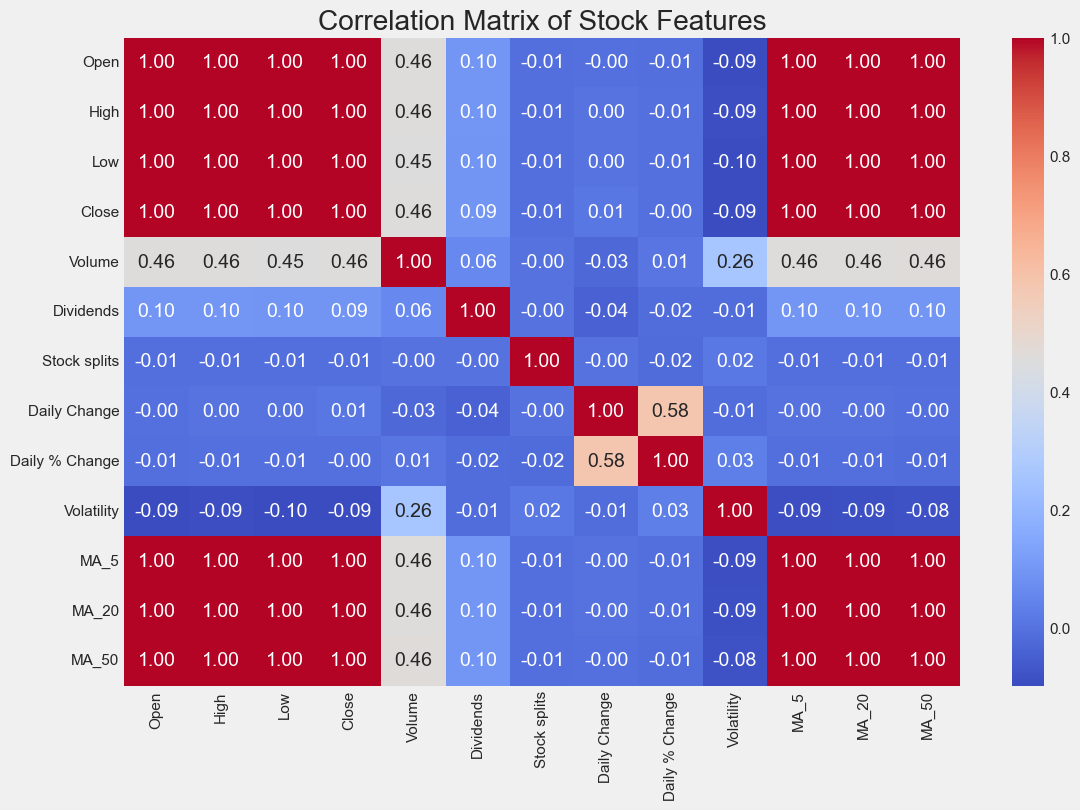

In [112]:
# -----------------------------
# 8. Correlation Matrix
# -----------------------------
numeric_features = history_df.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Stock Features")
plt.show()

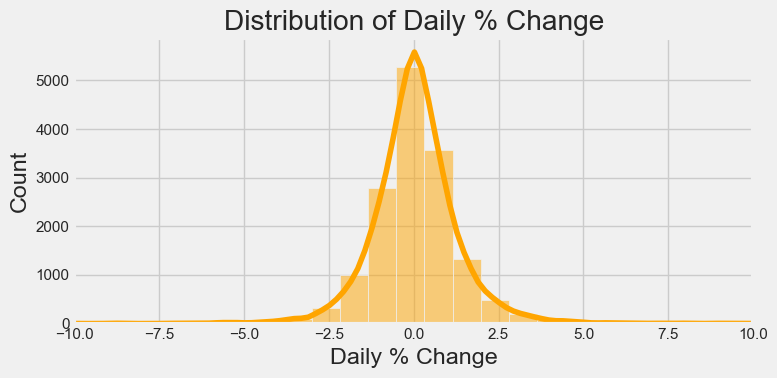

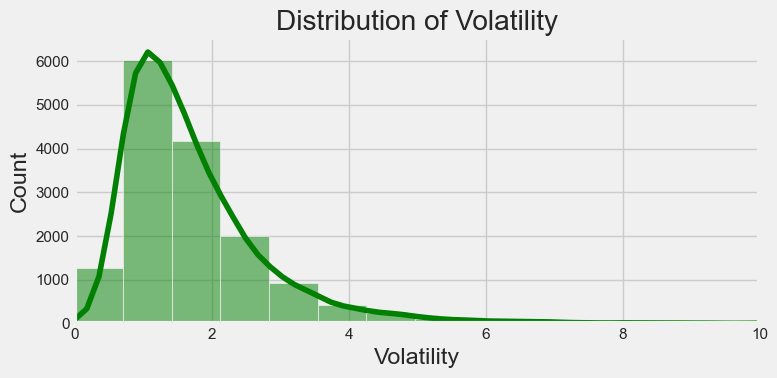

In [113]:
# -----------------------------
# 9. Histograms
# -----------------------------
plt.figure(figsize=(8, 4))
sns.histplot(history_df['Daily % Change'], bins=50, kde=True, color='orange')
plt.xlim(-10, 10)
plt.title("Distribution of Daily % Change")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(history_df['Volatility'], bins=50, kde=True, color='green')
plt.xlim(0, 10)
plt.title("Distribution of Volatility")
plt.tight_layout()
plt.show()

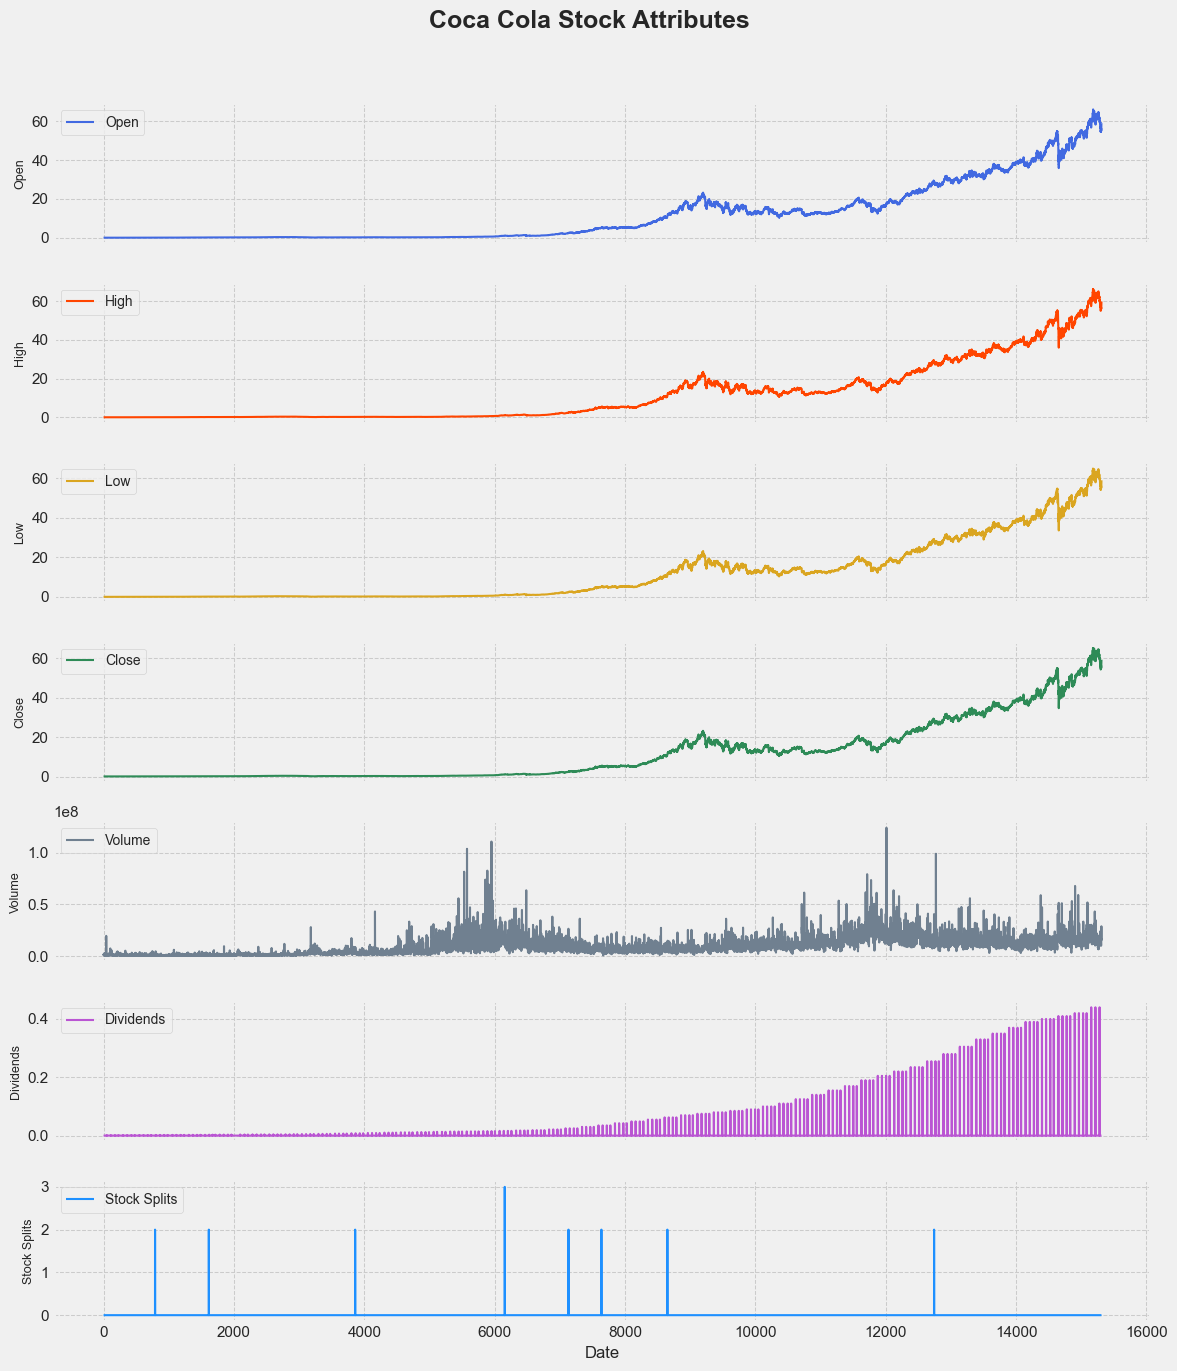

In [ ]:
# -----------------------------
# Basic EDA
# -----------------------------

# Define plot attributes
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
# Distinctive and vibrant colors
colors = ['royalblue', 'orangered', 'goldenrod', 'seagreen', 'slategray', 'mediumorchid', 'dodgerblue']

# Set up the figure
fig, axs = plt.subplots(len(columns), 1, figsize=(12, 14), sharex=True)
fig.suptitle('Coca Cola Stock Attributes', fontsize=18, fontweight='bold')

# Plot each attribute
for i, (col, color) in enumerate(zip(columns, colors)):
    axs[i].plot(history_df.index, history_df[col], color=color, label=col, linewidth=1.5)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, linestyle='--', linewidth=0.75)
    axs[i].set_ylabel(col, fontsize=9)

# Label and layout adjustments
plt.xlabel("Date", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for title
plt.show()


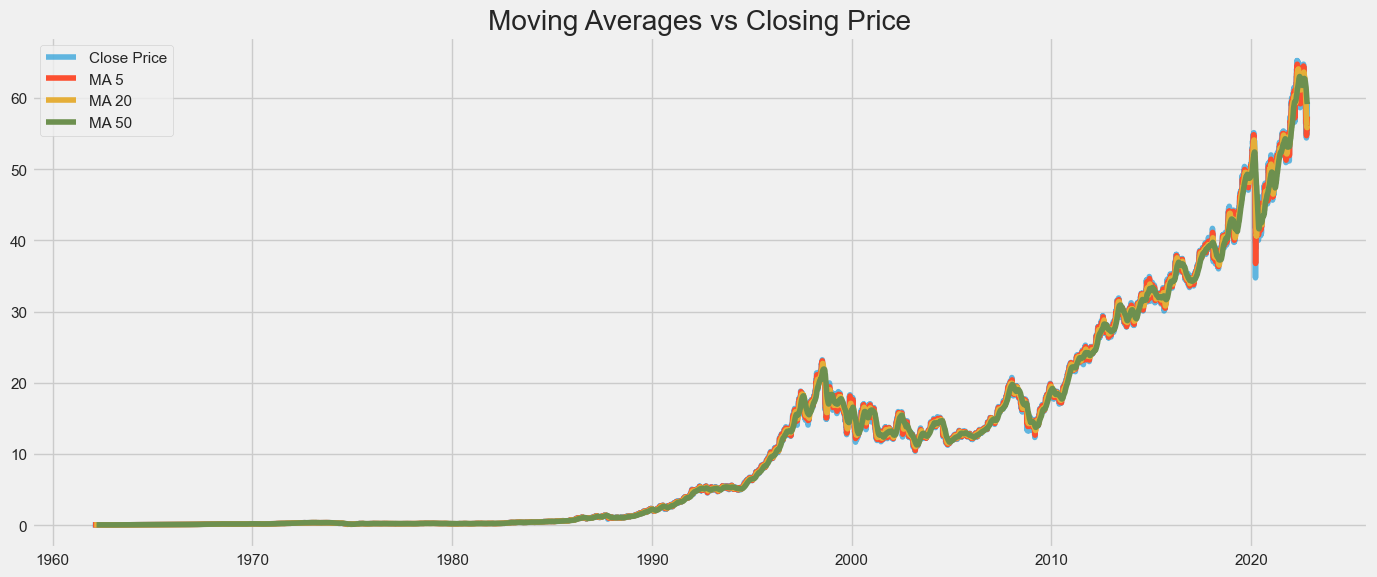

In [114]:
# -----------------------------
# 11. Plot Moving Averages
# -----------------------------
plt.figure(figsize=(14, 6))
plt.plot(history_df['Date'], history_df['Close'], label='Close Price', alpha=0.6)
plt.plot(history_df['Date'], history_df['MA_5'], label='MA 5', linestyle='-')
plt.plot(history_df['Date'], history_df['MA_20'], label='MA 20', linestyle='-')
plt.plot(history_df['Date'], history_df['MA_50'], label='MA 50', linestyle='-')
plt.legend()
plt.title("Moving Averages vs Closing Price")
plt.tight_layout()
plt.show()

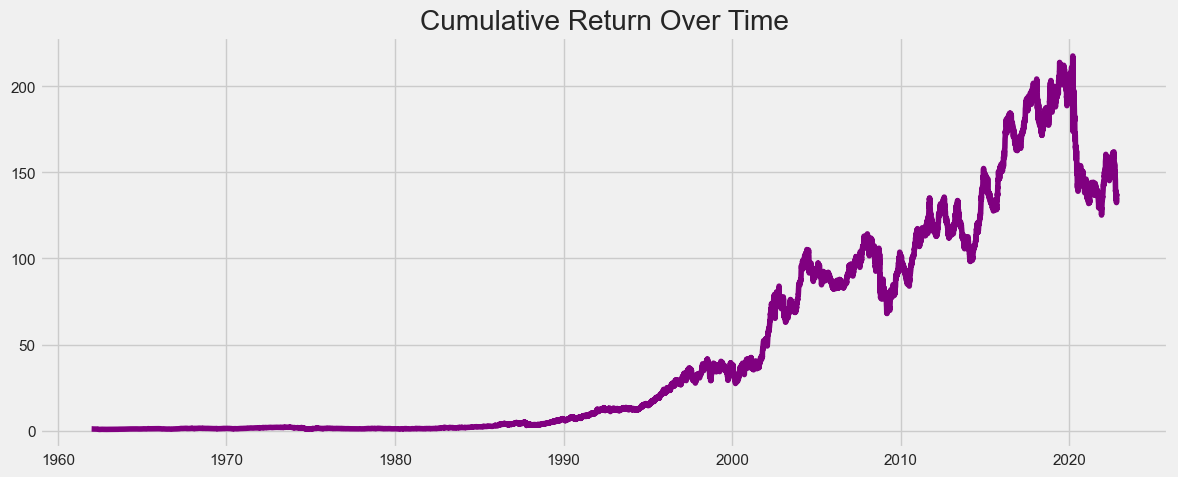

In [115]:
# -----------------------------
# 12. Cumulative Returns
# -----------------------------
history_df['Cumulative Return'] = (1 + history_df['Daily % Change'] / 100).cumprod()
plt.figure(figsize=(12, 5))
plt.plot(history_df['Date'], history_df['Cumulative Return'], color='purple')
plt.title("Cumulative Return Over Time")
plt.tight_layout()
plt.show()

In [116]:
# -----------------------------
# 13–14. Annualized Return & Sharpe
# -----------------------------
daily_return_mean = history_df['Daily % Change'].mean()
daily_volatility = history_df['Daily % Change'].std()
annualized_return = daily_return_mean * 252
annualized_volatility = daily_volatility * np.sqrt(252)
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
risk_free_rate = 0.05
sharpe_ratio = (annualized_return - (risk_free_rate * 100)) / annualized_volatility
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Annualized Return: 10.18%
Annualized Volatility: 20.35%
Sharpe Ratio: 0.25


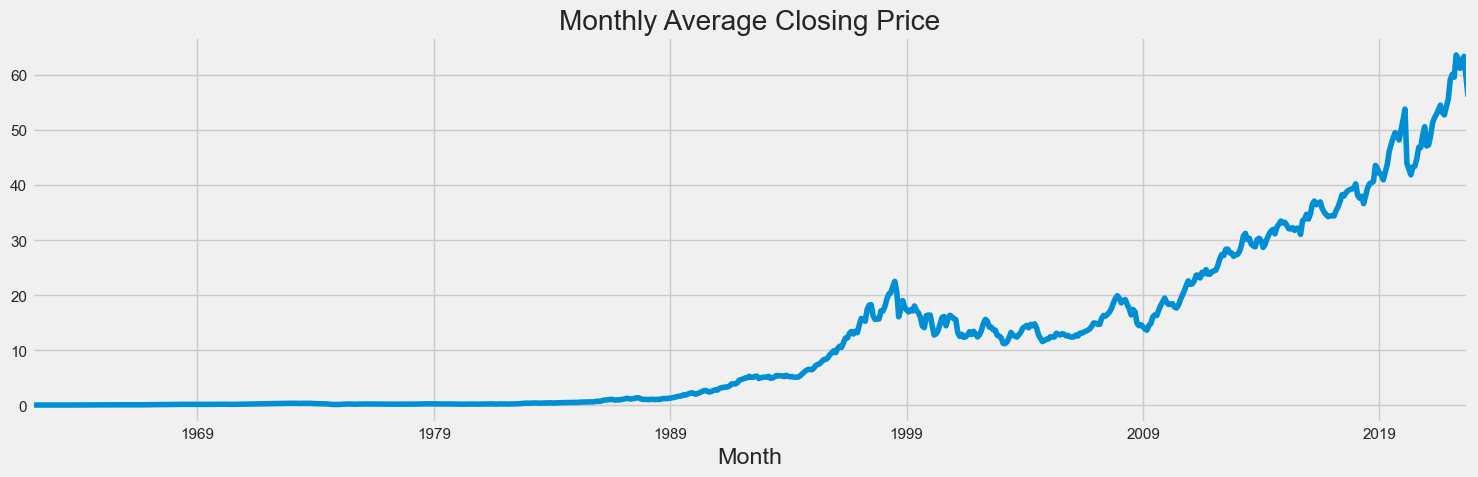

In [117]:
# -----------------------------
# 15. Monthly Average Price
# -----------------------------
monthly_df = history_df.copy()
monthly_df['Month'] = monthly_df['Date'].dt.to_period('M')
monthly_avg = monthly_df.groupby('Month')['Close'].mean()
monthly_avg.plot(figsize=(15, 5), title="Monthly Average Closing Price")
plt.tight_layout()
plt.show()

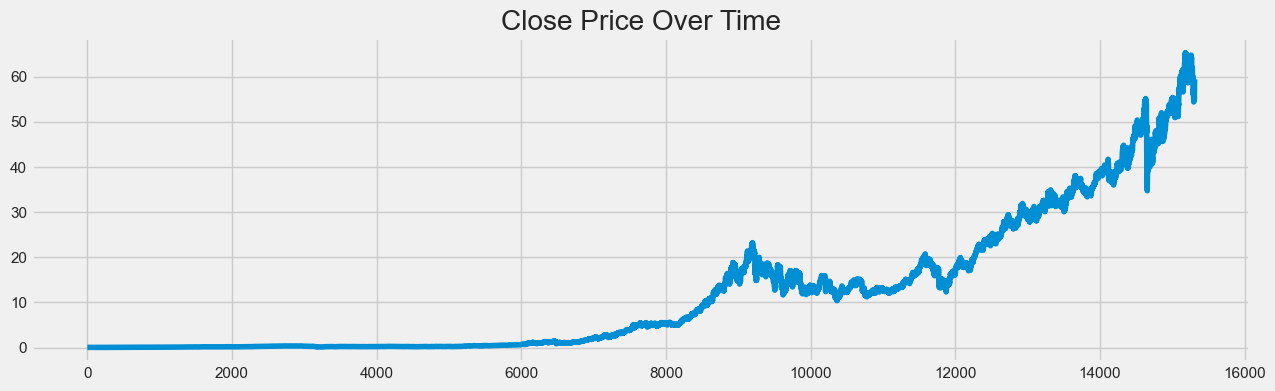

In [118]:
# Plot Close Price Over Time
plt.figure(figsize=(14,4))
plt.plot(history_df['Close'])
plt.title("Close Price Over Time")
plt.show()

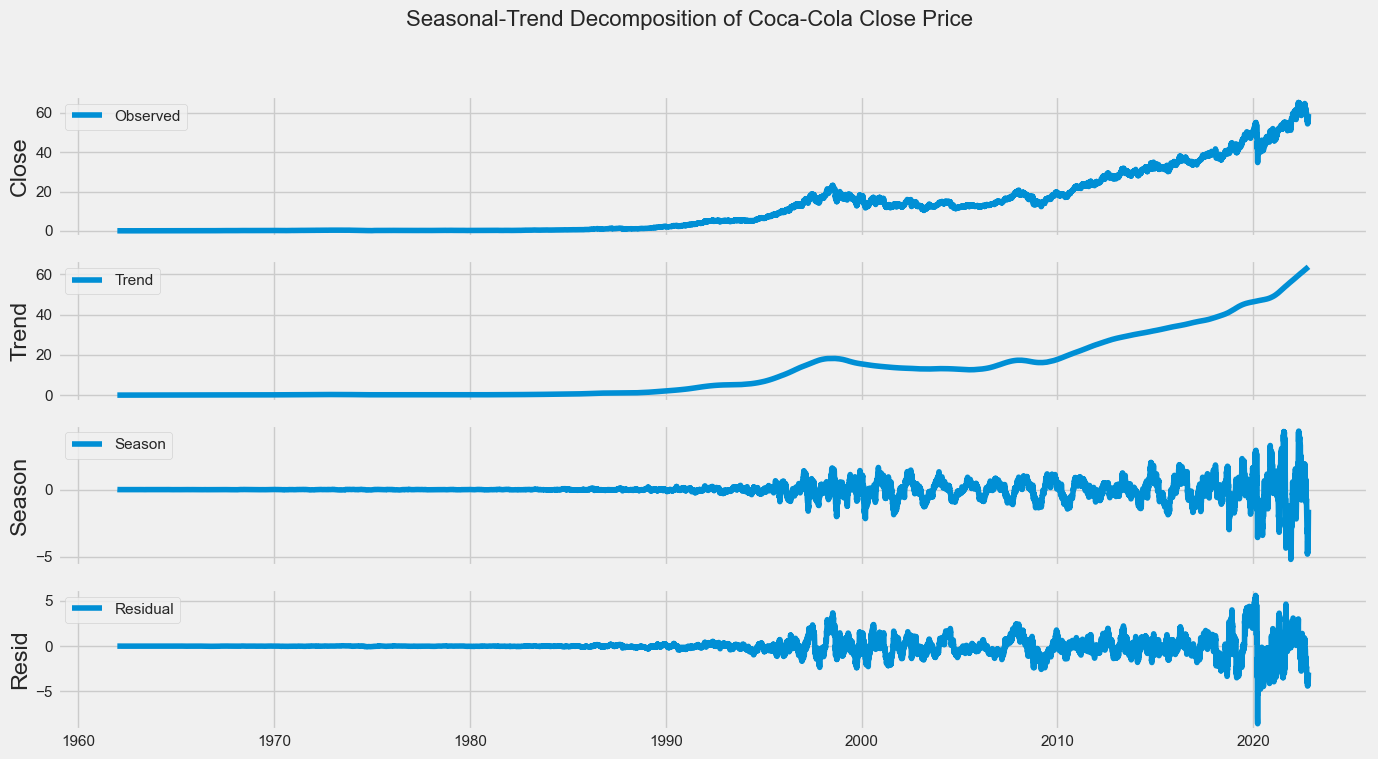

In [28]:
# Preprocess data
history_df['Date'] = pd.to_datetime(history_df['Date'], utc=True, format='ISO8601')
history_df.set_index('Date', inplace=True)

# Apply STL decomposition
stl = STL(history_df['Close'], period=365)
res = stl.fit()

# Custom plot with desired figure size
fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

axes[0].plot(res.observed, label='Observed')
axes[0].set_ylabel('Close')
axes[0].legend()

axes[1].plot(res.trend, label='Trend')
axes[1].set_ylabel('Trend')
axes[1].legend()

axes[2].plot(res.seasonal, label='Season')
axes[2].set_ylabel('Season')
axes[2].legend()

axes[3].plot(res.resid, label='Residual')
axes[3].set_ylabel('Resid')
axes[3].legend()

fig.suptitle('Seasonal-Trend Decomposition of Coca-Cola Close Price', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title
plt.show()


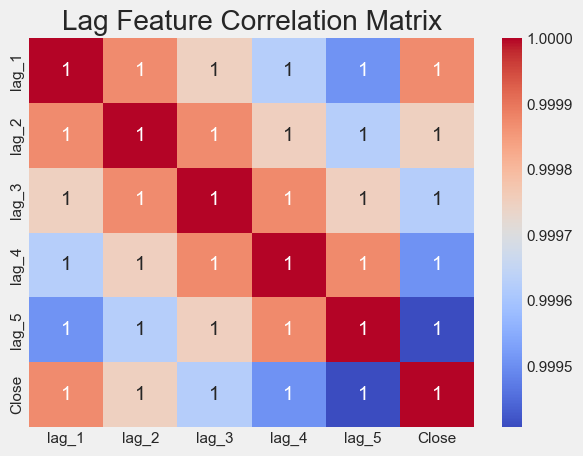

In [31]:
for lag in range(1, 6):
    history_df[f'lag_{lag}'] = history_df['Close'].shift(lag)
lag_corr = history_df[[f'lag_{i}' for i in range(1,6)] + ['Close']].corr()
sns.heatmap(lag_corr, annot=True, cmap='coolwarm')
plt.title("Lag Feature Correlation Matrix")
plt.show()

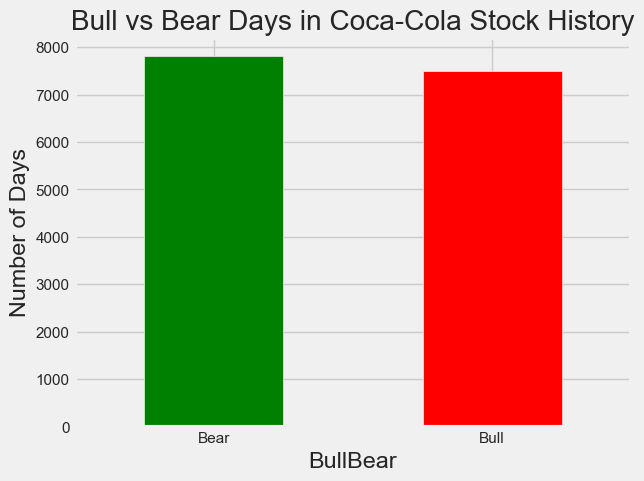

In [37]:
# Plot Bull vs Bear Days in Coca-Cola Stock History
history_df['BullBear'] = history_df['Close'].pct_change().apply(lambda x: 'Bull' if x > 0 else 'Bear')
history_df['BullBear'].value_counts().plot(kind='bar', color=['green', 'red'])

plt.title("Bull vs Bear Days in Coca-Cola Stock History")
plt.ylabel("Number of Days")
plt.xticks(rotation=0)
plt.show()


In [59]:
# -----------------------------
# EDA on Information CSV 
# -----------------------------

# Load info CSV with correct headers
info_df = pd.read_csv("Coca-Cola_stock_info.csv", header=None, names=['Description', 'Information'])

# Drop rows where 'Information' is missing
info_df = info_df.dropna()

# Convert 'Information' to numeric where possible
info_df['Information'] = pd.to_numeric(info_df['Information'], errors='coerce')

# Drop rows where numeric conversion failed
info_df = info_df.dropna().reset_index(drop=True)

# Verify it's clean
print(info_df.head())

         Description  Information
0                zip  30313.00000
1  fullTimeEmployees  80300.00000
2             maxAge      1.00000
3      ebitdaMargins      0.35199
4      profitMargins      0.23314


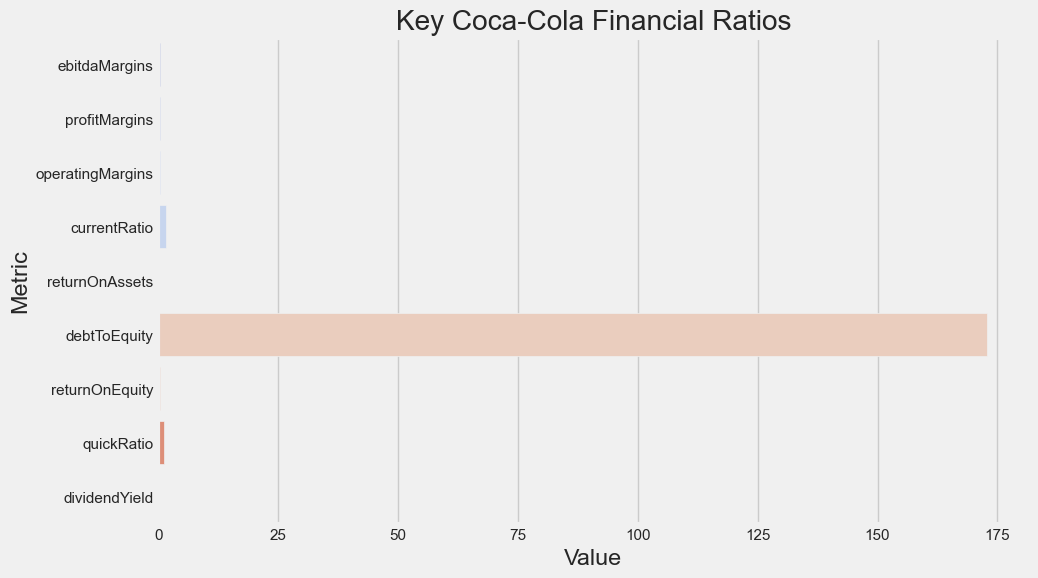

In [48]:
important_metrics = ['returnOnAssets', 'returnOnEquity', 'profitMargins', 'operatingMargins',
                     'ebitdaMargins', 'dividendYield', 'currentRatio', 'quickRatio', 'debtToEquity']

info_df = info_df[info_df['Description'].isin(important_metrics)].copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=info_df, x='Information', y='Description', palette='coolwarm')
plt.title('Key Coca-Cola Financial Ratios')
plt.xlabel('Value')
plt.ylabel('Metric')
plt.show()


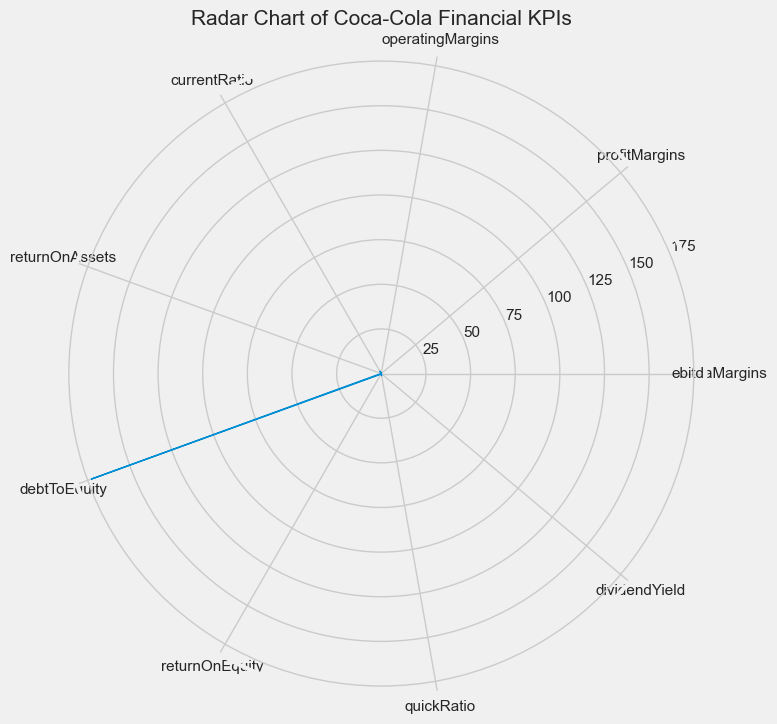

In [51]:
from math import pi

# Pivot data
kpi_pivot = info_df.set_index('Description').T
categories = list(kpi_pivot.columns)
values = kpi_pivot.iloc[0].values.flatten().tolist()
values += values[:1]

# Compute angles
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=1, linestyle='solid')
ax.fill(angles, values, alpha=0.3)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart of Coca-Cola Financial KPIs', size=15)
plt.show()

In [119]:
# -----------------------------
# 16–20. ML Features & Scaling
# -----------------------------
features = history_df[['Open', 'High', 'Low', 'Volume', 'Daily % Change', 'Volatility', 'MA_5', 'MA_20', 'MA_50']].bfill()
target = history_df['Close']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
# -----------------------------
# 21–22. ML Models
# -----------------------------
lr_model = LinearRegression().fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
print("Linear R²:", r2_score(y_test, y_pred_lr))
print("Linear RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear R²: 0.9997539434239471
Linear RMSE: 0.16856509409051523


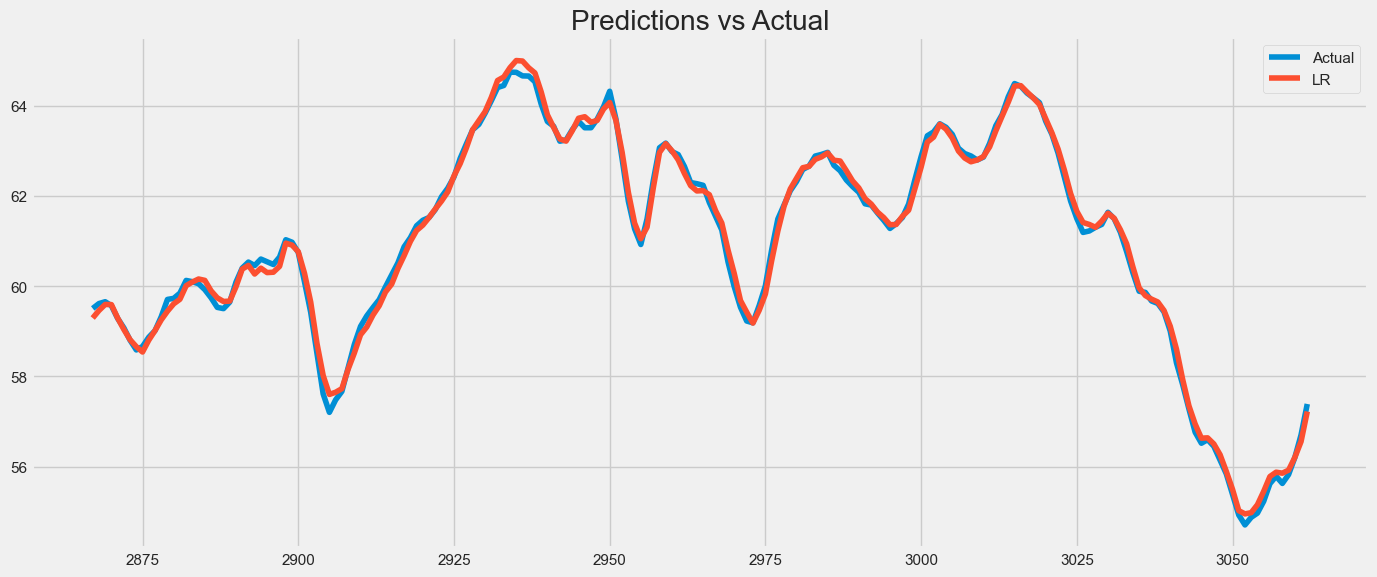

In [121]:
# -----------------------------
# 23. Plot Predictions
# -----------------------------
y_test_series = y_test.reset_index(drop=True)
y_pred_rf_series = pd.Series(y_pred_rf)
y_pred_lr_series = pd.Series(y_pred_lr)
plt.figure(figsize=(14, 6))
plt.plot(y_test_series[-200:].rolling(5).mean(), label='Actual')
plt.plot(y_pred_lr_series[-200:].rolling(5).mean(), label='LR')
plt.legend()
plt.title("Predictions vs Actual")
plt.tight_layout()
plt.show()

In [122]:
# Predicted vs Actual Returns Using Random Forest

# Copy original dataframe
df = history_df.copy()

# Calculate daily returns as target variable
df['Return'] = df['Close'].pct_change()

# Lag features for returns and volume to prevent leakage
df['Return_lag1'] = df['Return'].shift(1)
df['Return_lag2'] = df['Return'].shift(2)
df['Return_lag3'] = df['Return'].shift(3)
df['Volume_lag1'] = df['Volume'].shift(1)

# Moving averages and volatility on Close price (lagged)
df['MA_5'] = df['Close'].rolling(window=5).mean().shift(1)
df['MA_20'] = df['Close'].rolling(window=20).mean().shift(1)
df['Volatility'] = df['Close'].rolling(window=5).std().shift(1)

# Drop rows with NaN values created by shifting and rolling
df = df.dropna()

# Define features and target (next day return)
features = df[['Return_lag1', 'Return_lag2', 'Return_lag3', 'Volume_lag1', 'MA_5', 'MA_20', 'Volatility']]
target = df['Return']

# Train-test split (sequential)
split_index = int(len(features) * 0.8)
X_train, X_test = features.iloc[:split_index], features.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("RF R²:", r2_score(y_test, y_pred_rf))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

RF R²: -0.3831241910516281
RF RMSE: 0.0130253464139667


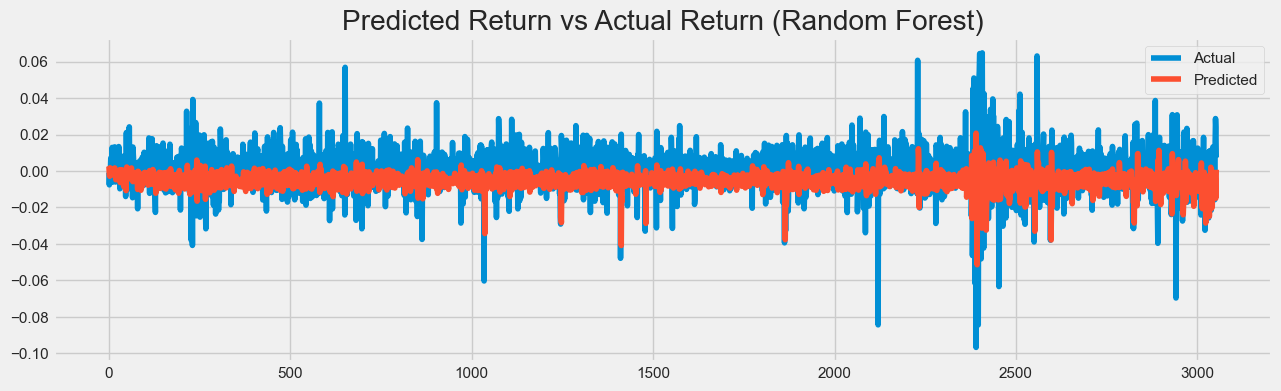

In [123]:
# Plot predictions vs actual returns
plt.figure(figsize=(14,4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.legend()
plt.title('Predicted Return vs Actual Return (Random Forest)')
plt.show()

In [124]:
df_lstm = history_df[['Date', 'Close']].copy()
df_lstm.set_index('Date', inplace=True)
scaled_data = MinMaxScaler().fit_transform(df_lstm)

def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)
X = X.reshape((X.shape[0], X.shape[1], 1))
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2/20
382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 1.3950e-04 - val_loss: 0.0017
Epoch 3/20
350/382 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2066e-04

In [ ]:
predicted = model.predict(X_test)
predicted = MinMaxScaler().fit(df_lstm).inverse_transform(predicted)
actual = MinMaxScaler().fit(df_lstm).inverse_transform(y_test.reshape(-1, 1))

96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


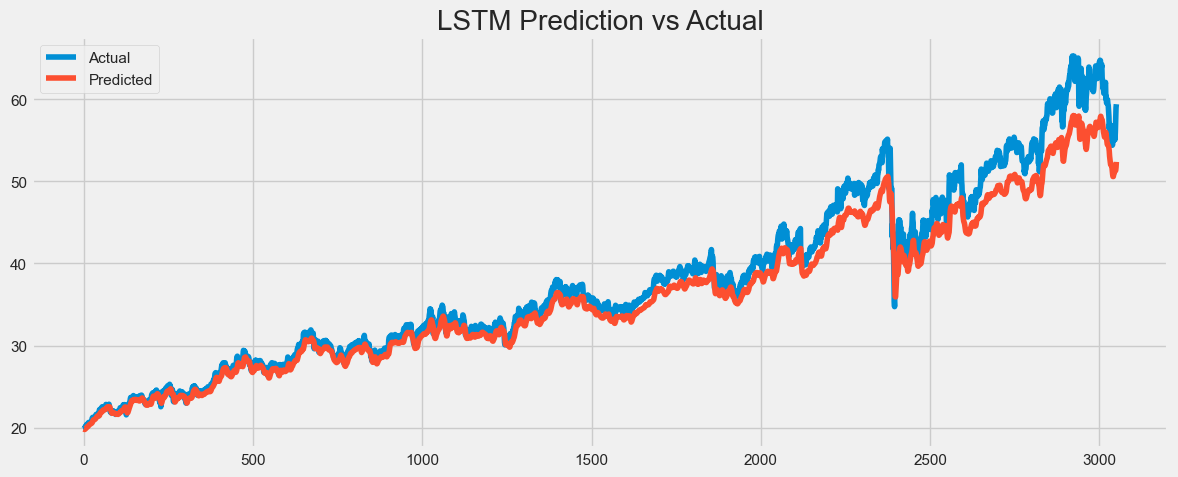

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title("LSTM Prediction vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 31. Predict Next Day
# -----------------------------
def predict_next_day(data_df, model, scaler=None):
    required_cols = ['Open', 'High', 'Low', 'Volume', 'Daily % Change', 'Volatility', 'MA_5', 'MA_20', 'MA_50']
    missing_cols = set(required_cols) - set(data_df.columns)
    if missing_cols:
        raise ValueError(f"Missing required features for prediction: {missing_cols}")

    latest_row = data_df[required_cols].iloc[-1:].bfill(axis=1)
    if scaler:
        latest_row = scaler.transform(latest_row)
    prediction = model.predict(latest_row)
    return prediction[0]

next_day_prediction = predict_next_day(history_df, rf_model, scaler=scaler)
print(f"Predicted next close price: ${next_day_prediction:.2f}")

Predicted next close price: $23.14
